In [1]:
# this lets us use the figures interactively
%matplotlib inline

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import plotly.express as px

plt.ion() # make the plotting interactive

In [2]:
# generate matplotlib handles to create a legend of the features we put in our map.
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles

In [3]:
def scale_bar(ax, location=(0.32, 0.95)):
    x0, x1, y0, y1 = ax.get_extent()
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    ax.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=9, transform=ax.projection)
    ax.plot([sbx, sbx - 5000], [sby, sby], color='k', linewidth=6, transform=ax.projection)
    ax.plot([sbx-5000, sbx - 10000], [sby, sby], color='w', linewidth=6, transform=ax.projection)

    ax.text(sbx, sby-1000, '10 km', transform=ax.projection, fontsize=10)
    ax.text(sbx-5000, sby-1000, '5 km', transform=ax.projection, fontsize=10)
    ax.text(sbx-8000, sby-1000, '0 km', transform=ax.projection, fontsize=10)


In [4]:
#import data file: flood, buildings, roads, population excel file, county outline, sa outline
flood= gpd.read_file(os.path.abspath('Project_datafiles/Flood_2m.shp'))
roads= gpd.read_file(os.path.abspath('Project_datafiles/Fermanagh_roads.shp'))
buildings= gpd.read_file(os.path.abspath('Project_datafiles/Building_Fermanagh.shp'))
pop_demography=gpd.read_file(os.path.abspath('Project_datafiles/pop_demography.csv'))
outline = gpd.read_file(os.path.abspath('Project_datafiles/Fermanagh_DCA.shp'))
small_area= gpd.read_file(os.path.abspath('Project_datafiles/SA_poly.shp'))
land_cover= gpd.read_file(os.path.abspath('Project_datafiles/LC_Fermanagh.shp'))

In [5]:
small_area =gpd.GeoDataFrame(pop_demography.merge(small_area, on="SA_Code"))
small_area.head()

,SA_Code,Age_75,Children_9,residents,geometry_x,SA,Shape_Leng,Shape_Area,geometry_y
0,N00002912,25,38,345,None,Ballinamallard ward,26671.860028,1.255163e+07,"POLYGON ((227161.047 350213.156, 227161.109 35..."
1,N00002921,21,31,309,None,Belcoo and Garrison ward,62798.682569,8.317093e+07,"POLYGON ((206591.234 353513.594, 206598.359 35..."
2,N00002922,33,65,468,None,Belcoo and Garrison ward,47129.291829,2.964456e+07,"POLYGON ((195507.891 357313.719, 195458.531 35..."
3,N00002924,19,31,386,None,Belleek and Boa ward,6016.303226,6.970221e+05,"POLYGON ((194939.719 358792.812, 194937.359 35..."
4,N00002925,20,43,311,None,Belleek and Boa ward,19160.475195,7.193503e+06,"POLYGON ((197286.328 359952.875, 197299.969 35..."


In [6]:
small_area= small_area.set_geometry('geometry_y')
small_area.geometry

0     POLYGON ((227161.047 350213.156, 227161.109 35...
1     POLYGON ((206591.234 353513.594, 206598.359 35...
2     POLYGON ((195507.891 357313.719, 195458.531 35...
3     POLYGON ((194939.719 358792.812, 194937.359 35...
4     POLYGON ((197286.328 359952.875, 197299.969 35...
5     POLYGON ((217257.859 365303.062, 217235.938 36...
6     POLYGON ((212900.172 360800.438, 212843.938 36...
7     POLYGON ((220325.609 345147.219, 220319.203 34...
8     POLYGON ((224635.609 343878.469, 224633.797 34...
9     POLYGON ((226659.703 344481.781, 226657.734 34...
10    POLYGON ((219265.688 352138.938, 219333.734 35...
11    POLYGON ((214762.625 357207.594, 214790.938 35...
12    POLYGON ((223555.719 345060.031, 223554.516 34...
13    POLYGON ((223486.719 344807.031, 223465.156 34...
14    POLYGON ((223129.719 345194.031, 223142.109 34...
15    POLYGON ((224110.750 344338.406, 224110.234 34...
16    POLYGON ((223045.547 347631.688, 223045.297 34...
17    POLYGON ((223980.281 345782.031, 223981.00

In [7]:
small_area['residents'] = small_area['residents'].astype(int)
small_area['Shape_Area'] = small_area['Shape_Area'].astype(int)


In [8]:
for ind, row in small_area.iterrows(): # iterate over each row in the GeoDataFrame
    small_area.loc[ind, 'population_density'] = row['residents']/ row['Shape_Area'] * 1000000
print(small_area.head())

     SA_Code Age_75 Children_9  residents geometry_x   
0  N00002912     25         38        345       None  \
1  N00002921     21         31        309       None   
2  N00002922     33         65        468       None   
3  N00002924     19         31        386       None   
4  N00002925     20         43        311       None   

                         SA    Shape_Leng  Shape_Area   
0       Ballinamallard ward  26671.860028    12551625  \
1  Belcoo and Garrison ward  62798.682569    83170934   
2  Belcoo and Garrison ward  47129.291829    29644558   
3      Belleek and Boa ward   6016.303226      697022   
4      Belleek and Boa ward  19160.475195     7193502   

                                          geometry_y  population_density  
0  POLYGON ((227161.047 350213.156, 227161.109 35...           27.486481  
1  POLYGON ((206591.234 353513.594, 206598.359 35...            3.715240  
2  POLYGON ((195507.891 357313.719, 195458.531 35...           15.787046  
3  POLYGON ((194939.

In [9]:
flood.to_crs(epsg = 2157)
roads.to_crs(epsg = 2157)
buildings.to_crs(epsg = 2157)
outline.to_crs(epsg = 2157)
small_area.to_crs(epsg = 2157)
land_cover.to_crs(epsg = 2157)

,SEGID,TOTPIXELS,COREPIXELS,BHSUB,LAND_COVER,Shape_Leng,Shape_Area,geometry
0,H000009r1,1785,1040,6.1,Neutral grass,20700.000000,1.115625e+06,"POLYGON ((597303.594 849201.689, 597303.594 84..."
1,H000015r1,2031,1419,7.1,Calcareous grass,17300.000000,1.269375e+06,"POLYGON ((593529.434 854200.632, 593529.434 85..."
2,H000017r1,5148,3700,10.2,Open dwarf shrub heath,33365.445406,2.699577e+06,"POLYGON ((599078.292 864323.421, 599078.291 86..."
3,H000023r1,0,0,12.1,Bog,4630.182956,4.091334e+05,"MULTIPOLYGON (((624405.618 823638.054, 624405...."
4,H000025r1,0,0,12.1,Bog,5076.466263,2.692242e+05,"MULTIPOLYGON (((614628.752 828910.970, 614628...."
...,...,...,...,...,...,...,...,...
37831,H172275r1,23,17,16.1,Inland Bare Ground,700.000000,1.437500e+04,"POLYGON ((628854.899 868778.303, 628829.904 86..."
37832,H172276r1,23,5,10.2,Open dwarf shrub heath,750.000000,1.437500e+04,"POLYGON ((629354.791 868728.311, 629354.791 86..."
37833,H172277r1,34,7,10.2,Open dwarf shrub heath,1100.000000,2.125000e+04,"POLYGON ((629354.791 868728.311, 629329.796 86..."
37834,H172278r1,36,8,12.1,Bog,1050.000000,2.250000e+04,"POLYGON ((629454.769 868678.321, 629429.774 86..."


In [10]:
def underwater(shapefile):
    flood_geom = flood['geometry'].values[0]
    underwater = shapefile['geometry'].within(flood_geom)
    return shapefile['geometry'].within(flood_geom)

In [11]:
lc_flooded = underwater(land_cover) # call underwater function to select land parcels in 5m flood zone
land_flooded = land_cover[lc_flooded] # subset the land cover shapefile to include only underwater = true
print(land_flooded)

           SEGID  TOTPIXELS  COREPIXELS  BHSUB             LAND_COVER   
7799   H032762r1         42          15   17.2       Continuous Urban  \
7846   H032815r1         26          16    1.1  Broad-leaved woodland   
10389  H035531r1         29           4    1.1  Broad-leaved woodland   
14105  H057963r1         29           5    1.1  Broad-leaved woodland   
14107  H057969r1         44          11    2.1    Coniferous woodland   
...          ...        ...         ...    ...                    ...   
35196  H165325r1         15           8   17.2       Continuous Urban   
35220  H165353r1         11           5    2.1    Coniferous woodland   
35258  H165397r1         22           9   16.1     Inland Bare Ground   
35260  H165399r1         15          15    2.1    Coniferous woodland   
35261  H165400r1         17           9    1.1  Broad-leaved woodland   

       Shape_Leng  Shape_Area   
7799        800.0     26250.0  \
7846        900.0     16250.0   
10389       750.0     18

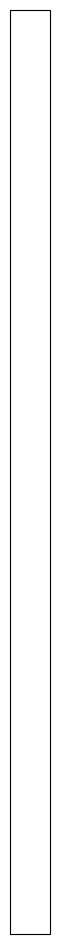

In [12]:
myFig = plt.figure(figsize=(12, 12))  # create a figure of size 10x10 (representing the page size in inches)

myCRS = ccrs.UTM(29)  # create a Universal Transverse Mercator reference system to transform our data.
# be sure to fill in XX above with the correct number for the UTM Zone that Northern Ireland is part of.

ax = plt.axes(projection=myCRS)  # finally, create an axes object in the figure, using a UTM projection,
# where we can actually plot our data.

In [13]:
# first, we just add the outline of Northern Ireland using cartopy's ShapelyFeature
outline_feature = ShapelyFeature(outline['geometry'], myCRS, edgecolor='k', facecolor='w')
xmin, ymin, xmax, ymax = flood.total_bounds
ax.add_feature(outline_feature) # add the features we've created to the map.
ax.set_extent([xmin-1000, xmax+1000, ymin-1000, ymax+1000], crs=myCRS)


In [14]:
# get the number of unique municipalities we have in the dataset
landcover_type = len(land_cover.LAND_COVER.unique())
print('Number of unique features: {}'.format(landcover_type))
landcover=list(land_cover.LAND_COVER.unique())

Number of unique features: 14


In [15]:
landcover_flooded = len(land_flooded.LAND_COVER.unique())
print('Number of unique features: {}'.format(landcover_flooded))
landflooded=list(land_flooded.LAND_COVER.unique())

Number of unique features: 10


In [16]:
landcover_colors = ['springgreen','olive', 'sienna','darkred', 'lawngreen', 'forestgreen','yellowgreen', 'y','darkgreen','darkorange','lightgrey','gold','black','grey']
for ii, name in enumerate(landcover):
    feat = ShapelyFeature(land_cover.loc[land_cover['LAND_COVER'] == name, 'geometry'], # first argument is the geometry
                          myCRS, # second argument is the CRS
                          edgecolor='k', # outline the feature in black
                          facecolor=landcover_colors[ii],
                        linewidth=0.1,
                         alpha=0.8) # set the face color to the corresponding color from the list
                           # set the outline width to be 1 pt
                           # set the alpha (transparency) to be 0.25 (out of 1)
    ax.add_feature(feat)


In [17]:
flood_feature = ShapelyFeature(flood['geometry'], myCRS, edgecolor='k',facecolor='navy',alpha=1,linewidth=0.1)
ax.add_feature(flood_feature)


In [18]:
land_flooded_colors = ['grey','darkgreen','forestgreen','lightgrey', 'gold','sienna','springgreen','lawngreen','olive','black']
for ii, name in enumerate(landflooded):
    feat = ShapelyFeature(land_flooded.loc[land_flooded['LAND_COVER'] == name, 'geometry'], # first argument is the geometry
                          myCRS, # second argument is the CRS
                          edgecolor='r', # outline the feature in black
                          facecolor=land_flooded_colors[ii],
                        linewidth=0.2,
                         alpha=1)
                          # set the face color to the corresponding color from the list
                           # set the outline width to be 1 pt
                           # set the alpha (transparency) to be 0.25 (out of 1)
ax.add_feature(feat)


In [19]:
landcover_handles = generate_handles(land_cover.LAND_COVER.unique(), landcover_colors)
flood_handles = generate_handles(['Flood'], ['navy'])

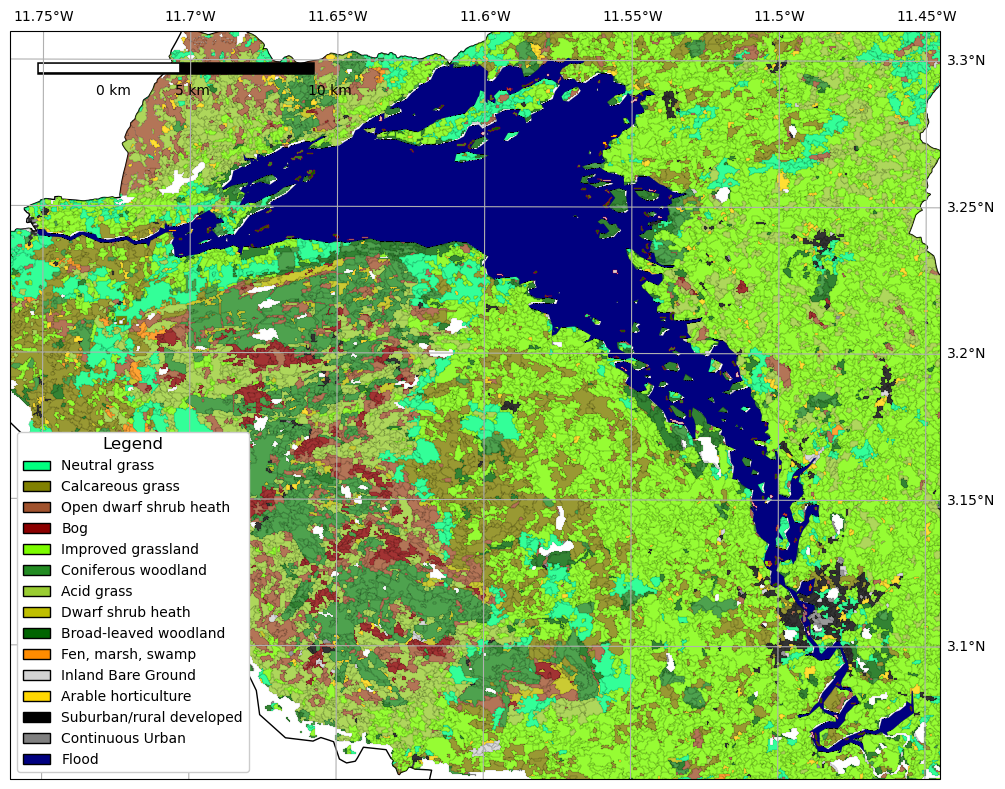

In [20]:
# ax.legend() takes a list of handles and a list of labels corresponding to the objects
# you want to add to the legend
handles = landcover_handles  + flood_handles # use '+' to concatenate (combine) lists
labels = landcover + ['Flood']

leg = ax.legend(handles, labels, title='Legend', title_fontsize=12,
                 fontsize=10, loc='lower left', frameon=True, framealpha=1)

gridlines = ax.gridlines(draw_labels=True, alpha=1, edgecolor='k') # draw  labels for the grid lines
                         
gridlines.left_labels = False # turn off the left-side labels
gridlines.bottom_labels = False

scale_bar(ax)
myFig # to show the updated figure

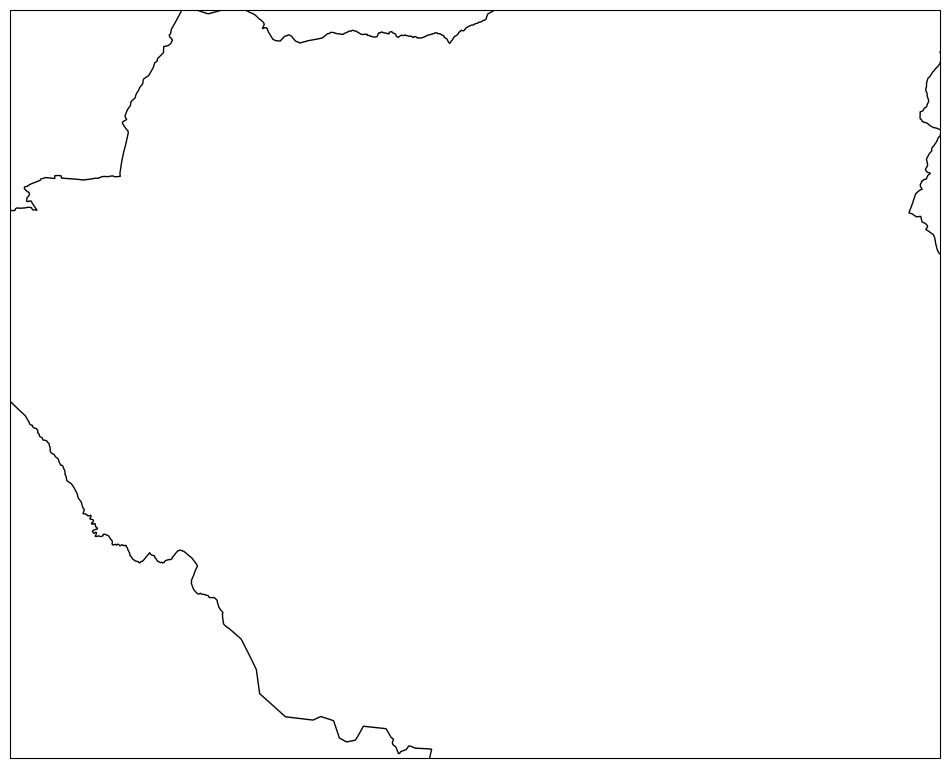

In [21]:
myFig2 = plt.figure(figsize=(12, 12))  # create a figure of size 10x10 (representing the page size in inches)

myCRS = ccrs.UTM(29)  # create a Universal Transverse Mercator reference system to transform our data.
# be sure to fill in XX above with the correct number for the UTM Zone that Northern Ireland is part of.

ax = plt.axes(projection=myCRS)  

# first, we just add the outline of Northern Ireland using cartopy's ShapelyFeature
outline_feature = ShapelyFeature(outline['geometry'], myCRS, edgecolor='k', facecolor='w')
xmin, ymin, xmax, ymax = flood.total_bounds
ax.add_feature(outline_feature) # add the features we've created to the map.
ax.set_extent([xmin-1000, xmax+1000, ymin-1000, ymax+1000], crs=myCRS)# finally, create an axes object in the figure, using a UTM projection,
# where we can actually plot our data.

In [35]:
flood_feature = ShapelyFeature(flood['geometry'], myCRS, edgecolor='k',facecolor='navy',alpha=0.5,linewidth=0.1)
ax.add_feature(flood_feature)#

roads_feature = ShapelyFeature(roads['geometry'], myCRS, edgecolor='k', linewidth=0.5)
ax.add_feature(roads_feature)



In [36]:
# ShapelyFeature creates a polygon, so for point data we can just use ax.plot()
residential=buildings.loc[buildings['CLASSIFICA']=='Residential']
residential_handle= ax.plot(residential.geometry.x, residential.geometry.y, 's', color='b', ms=2, transform=myCRS)

commercial=buildings.loc[buildings['CLASSIFICA']=='Commercial']
commercial_handle=ax.plot(commercial.geometry.x, commercial.geometry.y, 'o', color='k', ms=2, transform=myCRS)

education=buildings.loc[buildings['CLASSIFICA']=='Education']
education_handle=ax.plot(education.geometry.x, education.geometry.y, '^', color='g', ms=2, transform=myCRS)

health=buildings.loc[buildings['CLASSIFICA']=='Health']
health_handle=ax.plot(health.geometry.x, health.geometry.y, '*', color='r', ms=2, transform=myCRS)

other=buildings.loc[buildings['CLASSIFICA']=='Other']
other_handle=ax.plot(other.geometry.x, other.geometry.y, 'h', color='y', ms=2, transform=myCRS)
myFig2

<GeoAxes: >

In [24]:
# set a variable that will call whatever column we want to visualise on the map
#myFig2= small_area.explore('population_density', cmap='viridis')
# set the range for the choropleth

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
myFig2= small_area.plot(column='population_density', ax=ax, vmin=4, vmax=9171, cmap='magma',
                       legend=True, cax=cax, legend_kwds={'label': 'Resident Population'})


smallarea_outlines = ShapelyFeature(small_area['geometry_y'], myCRS, edgecolor='r', facecolor='none')

ax.add_feature(smallarea_outlines)
                         


myFig2

<GeoAxes: >

<Figure size 640x480 with 0 Axes>

In [25]:
roads_handle = [mlines.Line2D([], [], color='k')]
flood_handle = generate_handles(['Flood'], ['navy'])

In [26]:
# ax.legend() takes a list of handles and a list of labels corresponding to the objects
# you want to add to the legend
handles = roads_handle  + flood_handle + residential_handle + commercial_handle + other_handle + health_handle + education_handle # use '+' to concatenate (combine) lists
labels = ['Roads'] + ['Flood'] + ['Residential'] + ['Commercial'] + ['Other'] + ['Health'] + ['Education']

leg = ax.legend(handles, labels, title='Legend', title_fontsize=12,
                 fontsize=10, loc='lower left', frameon=True, framealpha=1)

gridlines = ax.gridlines(draw_labels=True, alpha=1, edgecolor='k') # draw  labels for the grid lines
                         
gridlines.left_labels = False # turn off the left-side labels
gridlines.bottom_labels = False

scale_bar(ax)
myFig2 # to show the updated figure

<GeoAxes: >

In [27]:
#create % column for elderly and child ?

In [28]:
#create column pop density

In [29]:
#all data shapefile clipped to flood polygon with within

In [30]:
#analyses:-tot pop in flood polygon
#         - nbr resident houses
#         - tot length of road impacted and class A roas
#         - Sa with highest pop density and if any are adjacent
#         - SA with less than avg pop density
#         - which landcover types has highest area in flood poly
#         - total area flooded per landcover types
#         - SA with highest % of elderly/child
#         - SA with low pop density but high child %
#         - SA with medical building
#         - residential building furtherest from medical build (use original dataset ?)
#         - SA centre furthest from medical building

In [31]:
#add scale and legend handle

In [32]:
#create map and add features to map
# do second map with landcover

In [33]:
#different labels depending on building class and road class

In [34]:
#grid lines